# Preprocessing - we have information in a few different sources and formats, so in this notebook we pull it all together and create a `YML` configuration file to provide all the information to `modflow-setup` 

In [1]:
# first we need to import all the modules we will use
import sys
sys.path.append('../../dependencies/')
import yaml
import matplotlib.pyplot as plt
import rasterio
from rasterio import features
import geopandas as gp
import pandas as pd
from pathlib import Path
import numpy as np
from shapely.geometry import Point, LineString

# Let's check out the proposed domain to get some coordiante information --- `geopandas` is a powerful tool for interacting with shapefiles in python, so we can use it to both read in the information we need and to visualize it

In [2]:
datapath = Path('../data/sgn/')

In [3]:
# we read this into a GeoDataFrame - 
# like a pandas dataframe that is geographically aware/located
domain = gp.read_file(datapath / 'shp' / 'Model_domain.shp')

<Axes: >

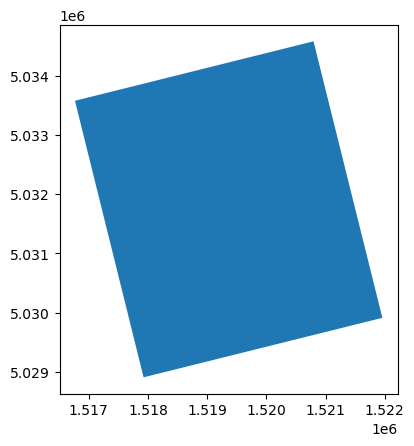

In [4]:
domain.plot()

### what's the projection?

In [5]:
domain.crs

<Projected CRS: EPSG:3003>
Name: Monte Mario / Italy zone 1
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: Italy - onshore and offshore - west of 12°E.
- bounds: (5.93, 36.53, 12.0, 47.04)
Coordinate Operation:
- name: Italy zone 1
- method: Transverse Mercator
Datum: Monte Mario
- Ellipsoid: International 1924
- Prime Meridian: Greenwich

### and what are the bounding points? We can navigate this using min and max x and y points because we know the rotation is anticlockwise

In [6]:
x,y = domain.geometry[0].exterior.coords.xy
xul, yul = x[np.argmin(x)],y[np.argmin(x)]
xtop, ytop = x[np.argmax(y)],y[np.argmax(y)]
xll, yll = x[np.argmin(y)],y[np.argmin(y)]
xlr,ylr = x[np.argmax(x)],y[np.argmax(x)]

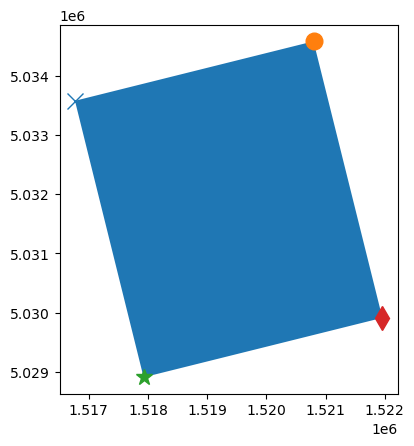

In [7]:
ax = domain.plot(color=None)
ax.plot(xul,yul, 'x', ms=12)    # x mark
ax.plot(xtop,ytop, 'o', ms=12)  # circle mark
ax.plot(xll,yll,'*', ms=12)     # star mark
ax.plot(xlr,ylr,'d', ms=12)     # diamond mark

### calculate the angle of rotation from upper left and top vertices using old-skool trigonometry (opposite over hypotenuse, etc)
## $\sin\theta=\frac{opposite}{hypotenuse}$
## $\theta=\sin^{-1} \frac{opposite}{hypotenuse}$

In [8]:
opp_over_hyp = np.abs(ytop-yul)/np.sqrt((xtop-xul)**2+(ytop-yul)**2)

In [9]:
opp_over_hyp

0.2419218955996804

In [10]:
theta = np.arcsin(opp_over_hyp)
theta = float(theta * 180/np.pi)
theta

14.000000000000748

### calculate the total length and width

In [11]:
length = np.round(np.sqrt((xll-xul)**2+(yll-yul)**2), decimals=-1)
width = np.round(np.sqrt((xll-xlr)**2+(yll-ylr)**2), decimals=-1)


# check out the recharge and geology

In [12]:
rch = gp.read_file(datapath / 'shp' / 'Recharge_4.shp')
rch.columns

Index(['DESCR', 'RCH_mmy', 'geometry'], dtype='object')

In [13]:
rch

,DESCR,RCH_mmy,geometry
0,1112 - tessuto residenziale continuo mediament...,0,"POLYGON ((1520308.207 5029502.839, 1520108.009..."
1,1112 - tessuto residenziale continuo mediament...,0,"MULTIPOLYGON (((1520632.506 5029583.63, 152061..."
2,1112 - tessuto residenziale continuo mediament...,0,"POLYGON ((1520863.446 5032363.4, 1520863.268 5..."
3,1111 - tessuto residenziale denso,0,"POLYGON ((1519765.622 5030484.334, 1519755.693..."
4,1111 - tessuto residenziale denso,0,"POLYGON ((1519449.388 5031397.53, 1519438.061 ..."
...,...,...,...
448,1412 - Aree verdi incolte,219,"POLYGON ((1519888.327 5031273.431, 1519864.768..."
449,1412 - Aree verdi incolte,219,"POLYGON ((1520964.014 5033000.417, 1520958.448..."
450,2111 ¿ seminativi semplici,0,"POLYGON ((1518890.217 5032505.676, 1518798.964..."
451,3223 - vegetazione degli argini sopraelevati,250,"POLYGON ((1517519.134 5030596.372, 1517519.207..."


<Axes: >

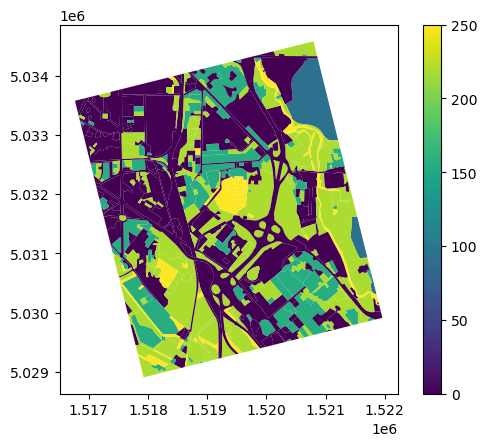

In [14]:
rch.plot(column = 'RCH_mmy', legend=True)


### it's easier if we burn this into a raster for `modflow-setup` to handle ATM

In [15]:
# open layer 2 bottom and read the metadata for the raster
bot2_rast = rasterio.open(datapath/ 'raster' / 'Bott_L2_fix.tif') 
rastermeta = bot2_rast.meta.copy()
rastermeta.update(compress='lzw') # set compression to be sure file is small as possible

In [18]:
# set up a tuple of geometry/recharge pairs from the recharge (mm/year column) shapefile
rchpolygons = ((geom,value) for geom, value in zip(rch.geometry, rch.RCH_mmy))
# and write it all out
with rasterio.open(datapath/ 'raster' / 'rch.tif', 'w+', **rastermeta) as ofp:
    out_arr = ofp.read(1)
    
    rchraster = features.rasterize(shapes=rchpolygons,
                                       fill=-9999,
                                       out=out_arr,
                                       transform=ofp.transform)
    ofp.write_band(1,rchraster)

AttributeError: 'numpy.ndarray' object has no attribute 'geometry'

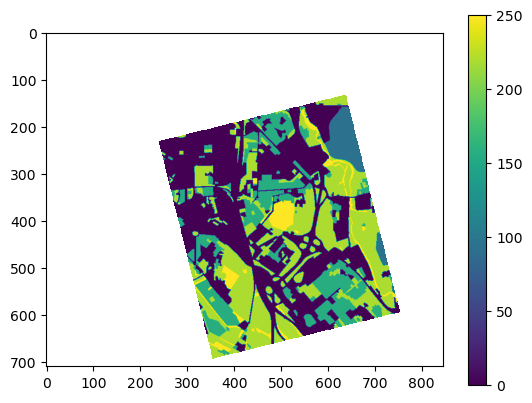

In [17]:
# confirm we wrote this ok by reading the raster back in and plotting it
with rasterio.open(datapath/ 'raster' / 'rch.tif') as src:
    rch = src.read(1)
rch[rch<-1] = np.nan
plt.imshow(rch)
plt.colorbar()

### now let's check out the geology

In [ ]:
geology = gp.read_file(datapath / 'shp' / 'Geology_250000_clip.shp')
geology.columns

In [ ]:
geology.plot(column = 'LITOLOGIA', legend=True)

### we can set starting Kh values as teh values provided to us: 
Gravel and sand = 0.0045  
Gravel, sand and silt = 0.0023

In [ ]:
geology['k'] = -999999
geology

In [ ]:
geology.loc[geology.LITOLOGIA == 'Gravel and sand', 'k'] = 0.0045

In [ ]:
geology

In [ ]:
geology.loc[geology.LITOLOGIA == 'Gravel, sand and silt', 'k'] = 0.0023
assert geology.k.min()>0 # this assert statment will throw an error if we have any k values of 0 or less
                         # it's embarassment prevention to be sure we assigned a real K value to each lithology

In [ ]:
geology.plot(column='k', legend=True)

#### We can use the same metadata and raster approach as we did for the recharge

In [ ]:
# set up a tuple of geomoetry/k-value pairs from the geology shapefile
geopolygons = ((geom,value) for geom, value in zip(geology.geometry, geology.k))
with rasterio.open(datapath/ 'raster' / 'k_field0.tif', 'w+', **rastermeta) as ofp:
    out_arr = ofp.read(1)
    
    georaster = features.rasterize(shapes=geopolygons,
                                       fill=-9999,
                                       out=out_arr,
                                       transform=ofp.transform)
    ofp.write_band(1,georaster)

In [ ]:
# confirm we wrote this ok
with rasterio.open(datapath/ 'raster' / 'k_field0.tif') as src:
    k0 = src.read(1)
k0[k0<-1] = np.nan
plt.imshow(k0)
plt.colorbar()

### for now, we will assign constant values to layers 2 and 3

In [ ]:
k1 = np.ones_like(k0) * 1e-8 # aquitard
k2 = np.ones_like(k0) * 2.3e-3 # deep aquifer

In [ ]:
with rasterio.open(datapath/ 'raster' / 'k_field1.tif', 'w+', **rastermeta) as ofp:
    ofp.write_band(1, k1)
with rasterio.open(datapath/ 'raster' / 'k_field2.tif', 'w+', **rastermeta) as ofp:
    ofp.write_band(1, k2)


### and let's see where the river is

In [ ]:
riv = gp.read_file(datapath / 'shp' / 'River_Lambro.shp')
riv

In [ ]:
ax = geology.plot(column='k', legend=True)
riv.plot(ax=ax)

### we need to add some information to the river

#### first break up into a handful of segments

In [ ]:
riv1 = riv.iloc[0].geometry

In [ ]:
rivpts = [Point(i) for i in riv1.coords]
# add a starting point and ending point each outside the domain
newpt = Point(rivpts[0].coords[0][0],rivpts[0].coords[0][1]+150)
rivpts.insert(0,newpt)
newpt = Point(rivpts[-1].coords[0][0]+150,rivpts[-1].coords[0][1]-150)
rivpts.append(newpt)

In [ ]:
# divide up the points in the polygon into 10 segments, each with 10% of the points
rivsegs = []
totpts = len(rivpts)/10
previous_seg = 0
for i in range(1,10):
    tmppts = rivpts[previous_seg:int(i*totpts)]
    previous_seg = int(i*totpts)-1
    rivsegs.append(LineString(zip([c.coords[0][0] for c in tmppts],
                                 [c.coords[0][1] for c in tmppts])))
tmppts = rivpts[previous_seg:-1]
rivsegs.append(LineString(zip([c.coords[0][0] for c in tmppts],
                                 [c.coords[0][1] for c in tmppts])))

In [ ]:
riv_divided = gp.GeoDataFrame({'geometry':rivsegs,
                               'segname': [i+1+1000 for i in range(len(rivsegs))]},
                                                                      crs=riv.crs)
riv_points = gp.GeoDataFrame({'geometry':rivpts,
                             'ptname' : np.arange(len(rivpts))},
                            crs=riv.crs)

In [ ]:
ax=riv_divided.plot(column='segname', legend=True, figsize=(8,10))
riv_points.plot(column='ptname', ax=ax)

## now set up routing - we can set up each segment to be routed to the upstream segment. routing to and from 0 indicates a stream entering or leaving the model domain

In [ ]:
riv_divided ['from_id'] = [i+1000 for i in range(len(riv_divided))]
riv_divided.loc[0, 'from_id'] = 0
riv_divided ['to_id'] = [i+2+1000 for i in range(len(riv_divided))]
riv_divided.loc[9, 'to_id'] = 0
# wild guess on river width
riv_divided['streamwid'] = 15

In [ ]:
riv_divided

In [ ]:
riv_divided.to_file(datapath / 'shp' / 'River_Lambro_segmented.shp')

## let's take a quick look at the raster data

In [ ]:
with rasterio.open(datapath/ 'raster' / 'DTM_domain.tif') as src:
    modtop = src.read(1)
plt.imshow(modtop)
plt.colorbar()

In [ ]:
with rasterio.open(datapath/ 'raster' / 'Bott_L1_fix.tif') as src:
    bot1 = src.read(1)
plt.imshow(bot1)
plt.colorbar()

In [ ]:
with rasterio.open(datapath/ 'raster' / 'Bott_L2_fix.tif') as src:
    bot2 = src.read(1)
plt.imshow(bot2)
plt.colorbar()

### we need a raster of the bottom of layer 2 kicked down by 60m to make the bottom of layer 3

In [ ]:
# open layer 2 again and read the metadata for the raster
bot2_rast = rasterio.open(datapath/ 'raster' / 'Bott_L2_fix.tif') 
meta_lay3 = bot2_rast.meta.copy()
meta_lay3.update(compress='lzw') # set compression to be sure file is small as possible
bot2_rast.close()

In [ ]:
# now subtract 60m from layer 2 and write out layer 3
bot3 = bot2-60.
plt.imshow(bot3)
plt.colorbar()

In [ ]:
with rasterio.open(datapath/ 'raster' / 'Bott_L3_fix.tif', 'w+', **meta_lay3) as ofp:
    ofp.write_band(1, bot3)
    

### now a quick check reading back in to make sure that worked

In [ ]:
with rasterio.open(datapath/ 'raster' / 'Bott_L3_fix.tif') as src:
    bot3 = src.read(1)
plt.imshow(bot3)
plt.colorbar()

### we need a csv file for the well package

In [ ]:
wells = gp.read_file(datapath / 'shp' / 'wells.shp')

In [ ]:
ax = domain.plot(facecolor="none", edgecolor='black')
wells.plot( ax=ax)

In [ ]:
wells.columns

In [ ]:
# let's set all the well names to lower case
wells.WellName = wells.WellName.apply(lambda x: x.lower())

In [ ]:
well_metadata = pd.read_csv(datapath / 'wells_with_elev.dat', index_col=0)
well_metadata.head()

In [ ]:
wells.head()

In [ ]:
len(well_metadata)

In [ ]:
#well_metadata = well_metadata.loc[well_metadata.q != 0]
len(well_metadata)

In [ ]:
well_metadata.head()

### let's pull together the well metadata with the pumping data

In [ ]:
well_data = well_metadata.merge(wells[['X','Y','WellName']], 
                                left_on='rootname', right_on='WellName')

In [ ]:
well_data.head()

In [ ]:
well_data = well_data.rename(columns = {'X':'x',
                                        'Y':'y',
                                        'laytop':'screen_top',
                                        'laybot':'screen_botm'})

In [ ]:
# need to add datetime for pumping
well_data['datetime'] = '2021-01-01'
well_data['enddatetime'] = '2022-12-31'

In [ ]:
well_data.head()

### Need to add in the barrier well, first have to get the information about top and bottom from the DTM and Layer rasters. Recall that these were read in above as `modtop` and `bot1`, respectively. But, we need to find the indices in row/column coordinates to read the values we need

In [ ]:
# we are given the coordinates of the barrier well
x_barrier, y_barrier = 1519614, 5031870

In [ ]:
# get the coordinates and read the model top and bottom of lay 1 elevations
# note that these rasters are at different resolutions, so must read unique coordinates
DTM_raster= rasterio.open(datapath/ 'raster' / 'DTM_domain.tif')
rDTM,cDTM = DTM_raster.index(x_barrier, y_barrier)
DTM_barrier = modtop[rDTM,cDTM]

In [ ]:
Lay1_raster= rasterio.open(datapath/ 'raster' / 'Bott_L1_fix.tif')
rLay1,cLay1 = Lay1_raster.index(x_barrier, y_barrier)
bot1_barrier = bot1[rLay1,cLay1]


In [ ]:
rasterio.transform.rowcol(Lay1_raster.transform, x_barrier, y_barrier)

#### drop out the zero pumping wells - we will add these back in with the Multi Aquifer Well package to provide communication across the aquitard

In [ ]:
well_no_pumping = well_data.loc[well_data.q == 0].copy()
well_no_pumping.loc[:,'screen_botm'] = -300 # set an arbitrarily low 
                                            # elevation for the screen bottom
well_no_pumping.index = range(len(well_no_pumping))
well_no_pumping[['q','x','y',
                                 'boundname','screen_top',
                                 'screen_botm', 'enddatetime',
                                 'datetime','laymidpt']].to_csv(datapath / 'wells_zero.csv')

In [ ]:
well_data_2 = well_data.loc[well_data.q != 0].copy()
well_data_2.loc[:,'datetime'] = '2022-01-01'

In [ ]:
well_data = pd.concat((well_data,well_data_2))

In [ ]:
well_data

In [ ]:
well_data = well_data.append(pd.DataFrame({'cellid':[np.nan],
                               'q':[-30/1000],
                              'x':[x_barrier],
                              'y':[y_barrier],
                              'boundname':['barrier'],
                              'screen_top':[DTM_barrier],
                              'screen_botm':[bot1_barrier],
                              'datetime':['2022-01-01'],
                              'enddatetime':['2022-12-31'],
                              'laymidpt':[np.mean((DTM_barrier, bot1_barrier))],
                              'layer':[0],
                              'cell':[np.nan],
                              'WellName':['barrier']}))

### save out the pumping data

In [ ]:
well_data[['q','x','y',
                   'boundname','screen_top',
                   'screen_botm', 'enddatetime',
                   'datetime','laymidpt']].to_csv(datapath / 'wells_nonzero.csv')


# Now we write the blocks for the model-building YML configuration file

# let's set a lateral discretization

In [ ]:
dxdy = 50 # this value, in meters, 
          # controls the lateral resolution of the entire model (what?!?)

In [ ]:
# use the technique at this link to preserve order of the YML output
# to make it easier for human readability
#https://stackoverflow.com/questions/31605131/dumping-a-dictionary-to-a-yaml-file-while-preserving-order/31609484

from collections import OrderedDict
def represent_dictionary_order(self, dict_data):
    return self.represent_mapping('tag:yaml.org,2002:map', dict_data.items())
   

In [ ]:
# start with an empty dictionary
config_data = OrderedDict()

In [ ]:
# make subdictionaries for each section
# SIMULATION BLOCK 
config_data['simulation'] = dict()
config_data['simulation']['sim_name'] = f'sgn_{dxdy}_sim'
config_data['simulation']['sim_ws'] = '../../models/sgn_mfsetup'
config_data['simulation']['version'] = 'mf6'
config_data['simulation']['options'] = dict()
config_data['simulation']['options']['continue'] = True
config_data


In [ ]:
# MODEL BLOCK
config_data['model'] = dict()
config_data['model']['external_path'] = './' 
config_data['model']['modelname'] = f'sgn_{dxdy}'
config_data['model']['relative_external_filepaths'] = True
config_data['model']['simulation'] = f'sgn_{dxdy}_sim'

# options subblock
config_data['model']['options'] = dict()
config_data['model']['options']['newton'] = True
config_data['model']['options']['newton_under_relaxation'] = True
config_data['model']['options']['print_input'] = True
config_data['model']['options']['save_flows'] = True
# packages block
config_data['model']['packages'] = ['dis', 'ims', 'ic', 'wel', 'oc',
                                    'npf', 'rch', 'sfr',"obs"]


In [ ]:
config_data

In [ ]:
config_data['intermediate_data'] = dict()
config_data['intermediate_data']['output_folder'] = 'original/'

In [ ]:
# set up the grid
config_data['setup_grid'] = dict()
config_data['setup_grid']['epsg'] = domain.crs.to_epsg() # read in from the domain crs
config_data['setup_grid']['rotation'] = float(np.round(theta, decimals=5)) # calculated above
config_data['setup_grid']['xoff'] = xll # calculated above - lower left corner
config_data['setup_grid']['yoff'] = yll # calculated above - lower left corner

In [ ]:
# set up the discretization
config_data['dis'] = dict()

In [ ]:
#dimensions block
config_data['dis']['dimensions'] = dict()
# from the calcs above and using the specified cell spacing
config_data['dis']['dimensions']['ncol'] = int(np.round(width/dxdy) )
config_data['dis']['dimensions']['nrow'] = int(np.round(length/dxdy) )
config_data['dis']['dimensions']['nlay'] = 3

config_data['dis']['drop_thin_cells'] =  True
config_data['dis']['minimum_layer_thickness'] = 1.0
config_data['dis']['remake_top'] = True

config_data['dis']['griddata'] = dict()
config_data['dis']['griddata']['delr'] = dxdy
config_data['dis']['griddata']['delc'] = dxdy

config_data['dis']['options'] = dict()
config_data['dis']['options']['length_units'] = 'meters'

In [ ]:
# now the source data for the dimenstions block above
config_data['dis']['source_data'] = dict()
config_data['dis']['source_data']['top'] = dict()
config_data['dis']['source_data']['top']['filename'] = \
            str(datapath/ 'raster' / 'DTM_domain.tif')
config_data['dis']['source_data']['top']['elevation_units'] = 'meters'

config_data['dis']['source_data']['botm'] = dict()
config_data['dis']['source_data']['botm']['filenames'] = dict()
config_data['dis']['source_data']['botm']['filenames'][0] =\
            str(datapath/ 'raster' / 'Bott_L1_fix.tif')
config_data['dis']['source_data']['botm']['filenames'][1] =\
            str(datapath/ 'raster' / 'Bott_L2_fix.tif')
config_data['dis']['source_data']['botm']['filenames'][2] =\
            str(datapath/ 'raster' / 'Bott_L3_fix.tif')


config_data['dis']['source_data']['botm']['elevation_units'] = 'meters'

In [ ]:
# time discretization - simple for steady state
config_data['tdis'] = dict()
config_data['tdis']['options'] = dict()
config_data['tdis']['options']['start_date_time'] = '2021-01-01'
config_data['tdis']['options']['time_units'] = 'seconds'
config_data['tdis']['perioddata'] = dict()
config_data['tdis']['perioddata']['group 1'] = dict()
config_data['tdis']['perioddata']['group 1']['nper'] = 1
config_data['tdis']['perioddata']['group 1']['perlen'] = 1.57e9 
config_data['tdis']['perioddata']['group 1']['nstp'] = 1
config_data['tdis']['perioddata']['group 1']['steady'] = True
config_data['tdis']['perioddata']['group 1']['tsmult'] = 1
config_data['tdis']['perioddata']['group 1']['start_date_time'] = '2021-01-01'
config_data['tdis']['perioddata']['group 1']['end_date_time'] = '2021-12-31'

# here we set up a second stress period for evaluating the barrier well
config_data['tdis']['perioddata']['group 2'] = dict()
config_data['tdis']['perioddata']['group 2'] = dict()
config_data['tdis']['perioddata']['group 2']['nper'] = 1
config_data['tdis']['perioddata']['group 2']['perlen'] = 1.57e9 
config_data['tdis']['perioddata']['group 2']['nstp'] = 1
config_data['tdis']['perioddata']['group 2']['steady'] = True
config_data['tdis']['perioddata']['group 2']['tsmult'] = 1
config_data['tdis']['perioddata']['group 2']['start_date_time'] = '2022-01-01'
config_data['tdis']['perioddata']['group 2']['end_date_time'] = '2022-12-31'


In [ ]:
# set in initial conditions as top of the model  for now
config_data['ic'] = dict()
config_data['ic']['strt_filename_fmt'] = \
    str(datapath/ 'raster' / 'DTM_domain.tif')



In [ ]:
# add in the wells
wellfile = str(datapath / 'wells_nonzero.csv')
config_data['wel'] = dict()
config_data['wel']['options'] = dict()
config_data['wel']['options']['print_input'] = True
config_data['wel']['options']['print_flows'] = True
config_data['wel']['options']['save_flows'] = True

config_data['wel']['source_data'] = dict()
config_data['wel']['source_data']['csvfiles'] = dict()

config_data['wel']['source_data']['csvfiles']['filenames'] = [wellfile]
config_data['wel']['source_data']['csvfiles']['volume_units'] = 'meters'

config_data['wel']['source_data']['csvfiles']['time_units'] = 'seconds'
config_data['wel']['source_data']['csvfiles']['data_column'] = 'q'
config_data['wel']['source_data']['csvfiles']['id_column'] = 'boundname'
config_data['wel']['source_data']['csvfiles']['datetime_column'] = 'datetime'
config_data['wel']['source_data']['csvfiles']['end_datetime_column'] = 'enddatetime'
config_data['wel']['source_data']['csvfiles']['period_stats'] = dict()
config_data['wel']['source_data']['csvfiles']['period_stats'][0] = ['mean', '2021-01-01', '2021-12-31']
config_data['wel']['source_data']['csvfiles']['period_stats'][1] = ['mean', '2022-01-01', '2022-12-31']



config_data['wel']['source_data']['csvfiles']['vertical_flux_distribution'] = dict()
config_data['wel']['source_data']['csvfiles']['vertical_flux_distribution']['across_layers'] = False
config_data['wel']['source_data']['csvfiles']['vertical_flux_distribution']['distribute_by'] = 'transmissivity'
config_data['wel']['source_data']['csvfiles']['vertical_flux_distribution']['screen_top_col'] = 'screen_top'
config_data['wel']['source_data']['csvfiles']['vertical_flux_distribution']['screen_botm_col'] = 'screen_botm'

#config_data['wel']['source_data']['csvfiles']['vertical_flux_distribution']['minimum_layer_thickess'] = 10


In [ ]:
# output control
config_data['oc'] = dict()
config_data['oc']['budget_fileout_fmt'] = '{}.cbc'
config_data['oc']['head_fileout_fmt'] = '{}.hds'
config_data['oc']['saverecord'] = dict()
config_data['oc']['saverecord'][0] = dict()

config_data['oc']['saverecord'][0]['budget'] = 'last'
config_data['oc']['saverecord'][0]['head'] = 'last'



In [ ]:
#node property flow
geology_file = str(datapath / 'raster' / 'k_field{}.tif')
config_data['npf'] = dict()
config_data['npf']['source_data'] = dict()
config_data['npf']['source_data']['k'] = dict()

config_data['npf']['source_data']['k']['filenames'] = dict()
config_data['npf']['source_data']['k']['filenames'][0] = geology_file.format(0)
config_data['npf']['source_data']['k']['filenames'][1] = geology_file.format(1)
config_data['npf']['source_data']['k']['filenames'][2] = geology_file.format(2)



In [ ]:
# recharge
rch_file = str(datapath / 'raster' / 'rch.tif')
config_data['rch'] = dict()
config_data['rch']['options'] = dict()
config_data['rch']['options']['print_output'] = True
config_data['rch']['options']['print_flows'] = False
config_data['rch']['options']['save_flows'] = True
config_data['rch']['options']['readasarrays'] = True
config_data['rch']['source_data'] = dict()
config_data['rch']['source_data']['recharge'] = dict()
config_data['rch']['source_data']['recharge']['filenames'] = dict()
config_data['rch']['source_data']['recharge']['filenames'][0] = rch_file
config_data['rch']['source_data']['recharge']['length_units'] = 'millimeters'
config_data['rch']['source_data']['recharge']['time_units'] = 'years'
config_data['rch']['source_data']['recharge']['period_stats'] = dict()
config_data['rch']['source_data']['recharge']['period_stats'][0] = 'mean'
config_data['rch']['source_data']['recharge']['period_stats'][1] = 'mean'




In [ ]:
# streamflow routing
rivfile = str(datapath / 'shp' / 'River_Lambro_segmented.shp')

In [ ]:
# for SFR observations, we need to make a CSV file with the segments identified
inriv = gp.read_file(rivfile)
inriv['obsname'] = [f'seg_{i}' for i in inriv.segname]
inriv.head()

In [ ]:
rivsegfile = str(datapath / 'csv' / 'river_segments.csv')
inriv[['segname', 'obsname']].to_csv(rivsegfile)

In [ ]:

config_data['sfr'] = dict()
config_data['sfr']['source_data'] = dict()
config_data['sfr']['source_data']['flowlines'] = dict()
config_data['sfr']['source_data']['flowlines']['filename'] = rivfile
config_data['sfr']['source_data']['flowlines']['id_column'] = 'segname'
config_data['sfr']['source_data']['flowlines']['routing_column'] = 'to_id'
config_data['sfr']['source_data']['flowlines']['width1'] = 'streamwid'
config_data['sfr']['source_data']['flowlines']['width2'] = 'streamwid'


config_data['sfr']['source_data']['dem'] = dict()
config_data['sfr']['source_data']['dem']['filename'] = \
         str(datapath/ 'raster' / 'DTM_domain.tif')
config_data['sfr']['source_data']['dem']['elevation_units'] = 'meters'

config_data['sfr']['source_data']['observations'] = dict()
config_data['sfr']['source_data']['observations']['filename'] = rivsegfile
config_data['sfr']['source_data']['observations']['obstype'] = \
        ['sfr','outflow', 'downstream-flow','ext-outflow']
config_data['sfr']['source_data']['observations']['line_id_column'] = 'segname'
config_data['sfr']['source_data']['observations']['obsname_column'] = 'obsname'

config_data['sfr']['set_streambed_top_elevations_from_dem'] = True



In [ ]:
# solver settings
config_data['ims'] = dict()
config_data['ims']['options'] = dict()
config_data['ims']['options']['print_options'] = 'all'
config_data['ims']['options']['complexity'] = 'moderate'
config_data['ims']['options']['no_ptc'] = 'all'

config_data['ims']['nonlinear'] = dict()
config_data['ims']['nonlinear']['outer_dvclose'] = 0.01
config_data['ims']['linear'] = dict()
config_data['ims']['linear']['inner_dvclose'] = 5e-6


In [ ]:
# add in head observations
config_data['obs'] = dict()
config_data['obs']['source_data'] = dict()
config_data['obs']['source_data']['filenames'] = '../../data/sgn/csv/heads_sep2019.csv'
config_data['obs']['source_data']['column_mappings'] = dict()

config_data['obs']['source_data']['column_mappings']['obsname'] = 'ID'
config_data['obs']['source_data']['column_mappings']['x'] = 'X'
config_data['obs']['source_data']['column_mappings']['y'] = 'Y'

In [ ]:
yaml.add_representer(OrderedDict, represent_dictionary_order)
with open('sgn_config.yml', 'w') as outfile:
    yaml.dump(config_data, outfile, default_flow_style=False)